In [1]:
from generator_model import Generator
from torch import optim
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from dataset import Image_dataset
import config
from tqdm import tqdm

gen = Generator(in_channels=3)
checkpoint = torch.load("genv2.pth.tar", map_location=torch.device(config.DEVICE))
gen.load_state_dict(checkpoint['state_dict'])
optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/album

In [2]:
val_dataset = Image_dataset(root_dir="image_dataset/drones/val")
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [3]:
val_dataset = Image_dataset(root_dir="image_dataset/drones/train")
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

all = {"x": [], "z": [], "y": [], "y_fake": []}

# x, y = next(iter(val_loader))

per = 25
for idx, (x,z,y) in tqdm(enumerate(val_loader)):
    if idx == per: break
    x, z, y = x.to(config.DEVICE), z.to(config.DEVICE), y.to(config.DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x,z)
        y_fake = y_fake * 0.5 + 0.5
        y = y * 0.5 + 0.5
        x = x * 0.5 + 0.5
    all["x"].append(x)
    all["z"].append(z)
    all["y"].append(y)
    all["y_fake"].append(y_fake)
    

7it [00:01,  4.70it/s]


In [4]:
def convert(x):
    return np.moveaxis(np.array(x[0, :, :, :]), 0, -1)

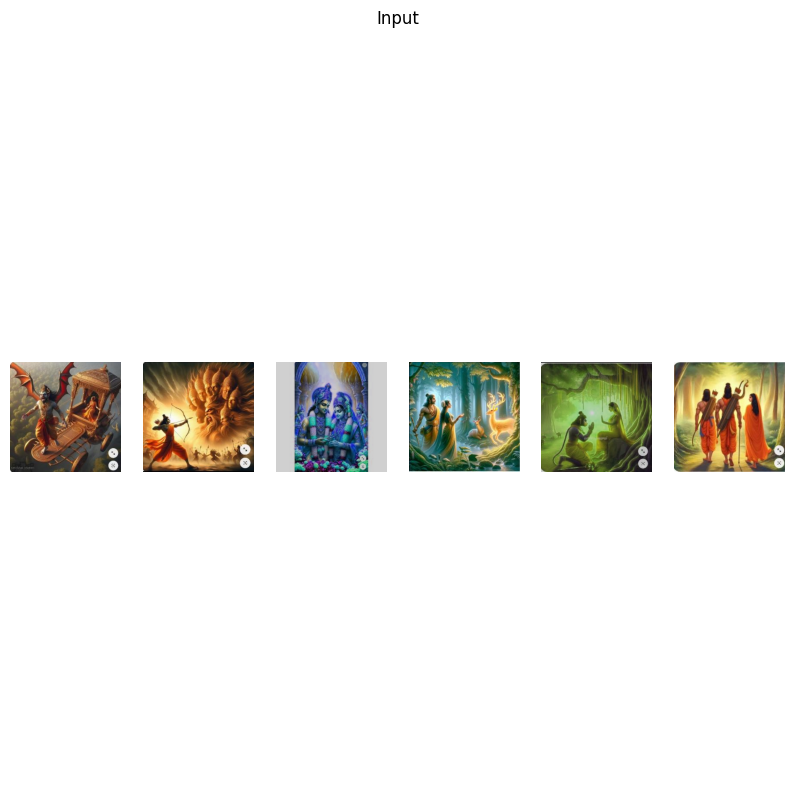

In [5]:
fig = plt.figure(figsize=(10, 10))
plt.title("Input")
plt.axis("off")
columns = 6
rows = 1
for i in range(1, columns*rows +1):
    img = convert(all['x'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")


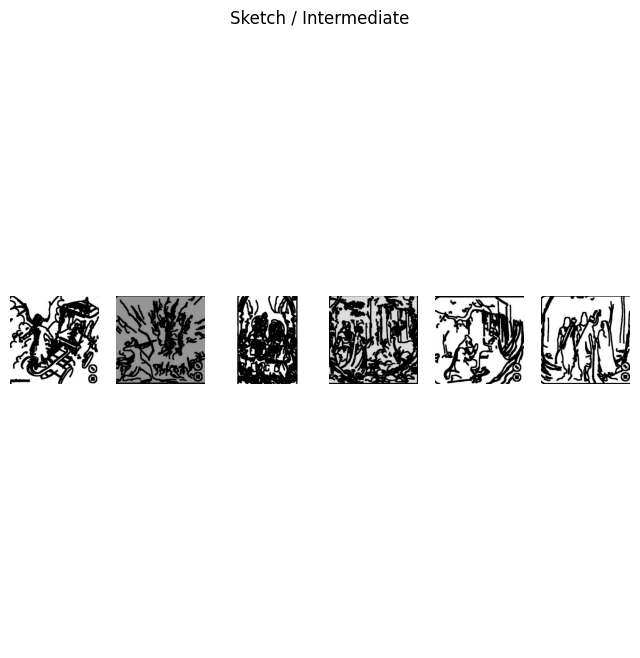

In [6]:
fig = plt.figure(figsize=(8, 8))
plt.title("Sketch / Intermediate")
plt.axis("off")

for i in range(1, columns*rows +1):
    img = convert(all['z'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.clip(0,1))
    plt.axis("off")


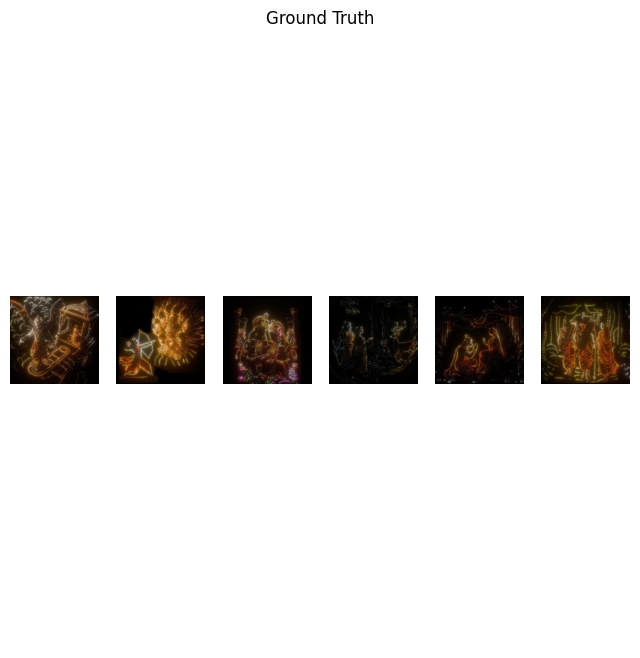

In [7]:
fig = plt.figure(figsize=(8, 8))

plt.title("Ground Truth")
plt.axis("off")

for i in range(1, columns*rows +1):
    img = convert(all['y'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.clip(0,1))
    plt.axis("off")


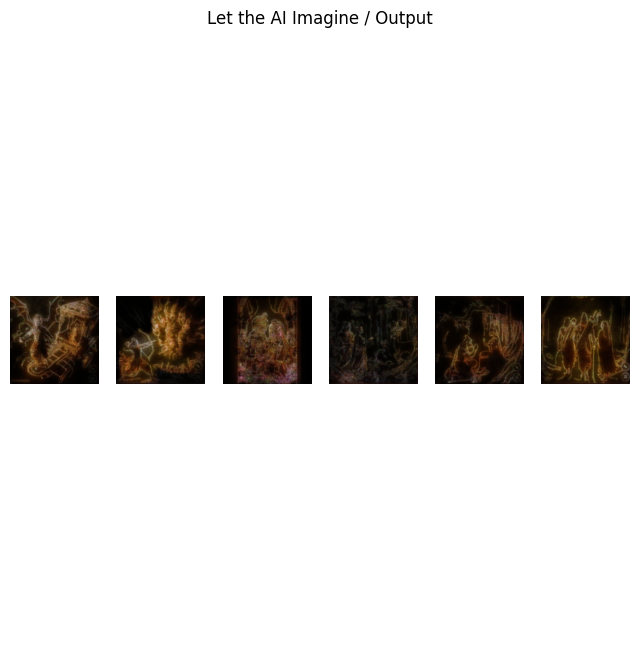

In [8]:
fig = plt.figure(figsize=(8, 8))

plt.title("Let the AI Imagine / Output")
plt.axis("off")

for i in range(1, columns*rows +1):
    img = convert(all['y_fake'][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")

In [9]:
image_pth = "image_dataset/drones/train/5.jpg"
image = np.array(Image.open(image_pth))
image_x = image[:, :256, ...]
image_z = image[:, 256:256*2, ...]
x = config.transform_only_input(image=image_x)["image"]
z = config.transform_only_input(image=image_z)["image"]

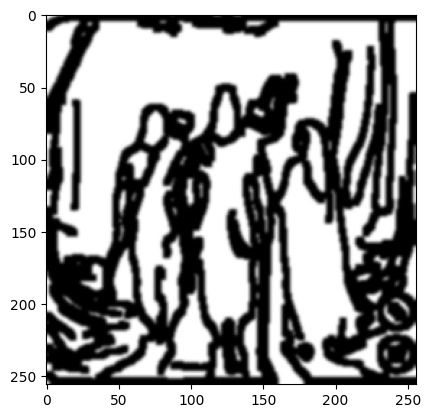

In [10]:
import utils
image_z_self = utils.image_to_line_art(image_x, thickenss=5)
z_self = config.transform_only_input(image=image_z_self)["image"]
plt.imshow(image_z_self)

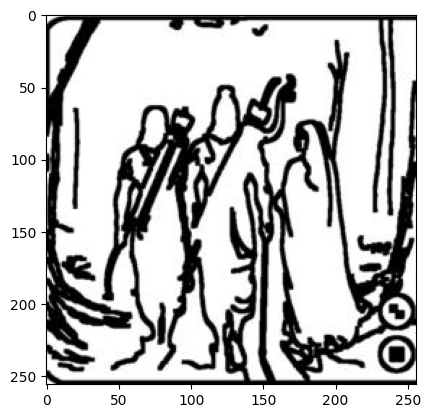

In [11]:
plt.imshow(image_z)

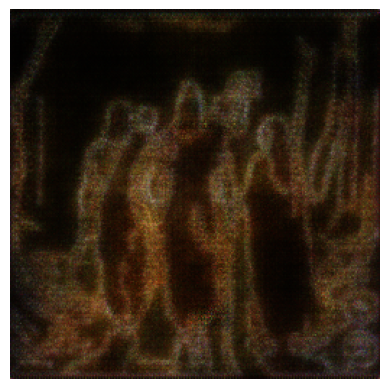

In [12]:
generated_image_self = gen(x.unsqueeze(0) ,z_self.unsqueeze(0)) * 0.5 + 0.5
generated_image_self = generated_image_self[0].permute(1,2,0).detach().numpy()

plt.imshow(generated_image_self)
plt.axis("off")
plt.imsave("Drone_output_self.jpg", generated_image_self)

In [13]:
import utils
image_z_self_empty = np.zeros_like(image_z)
z_self_empty = config.transform_only_input(image=image_z_self_empty)["image"]

In [14]:
generated_image = gen(x.unsqueeze(0) ,z.unsqueeze(0)) * 0.5 + 0.5
generated_image = generated_image[0].permute(1,2,0).detach().numpy()

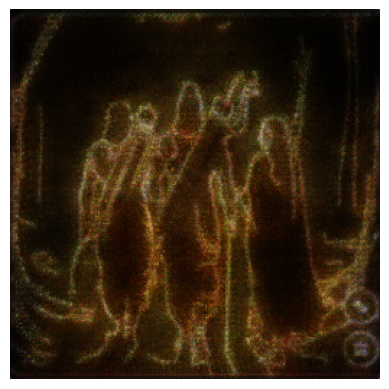

In [15]:
plt.imshow(generated_image)
plt.axis("off")
plt.imsave("Drone_output.jpg", generated_image)

In [16]:
generated_image_self_empty = gen(x.unsqueeze(0) ,z_self_empty.unsqueeze(0)) * 0.5 + 0.5
generated_image_self_empty = generated_image_self_empty[0].permute(1,2,0).detach().numpy()

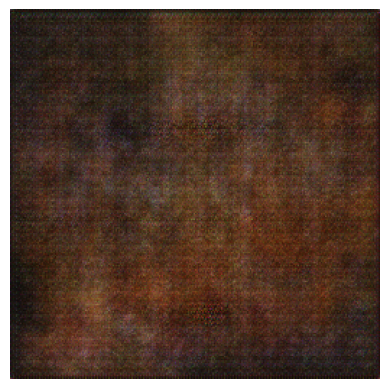

In [17]:
plt.imshow(generated_image_self_empty)
plt.axis("off")
plt.imsave("Drone_output_self_empty.jpg", generated_image_self_empty)